In [4]:
%matplotlib inline

import requests
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tenacity import retry, stop_after_attempt, wait_fixed, wait_random, wait_random_exponential
import concurrent.futures
import csv
import logging

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%y-%m-%d %H:%M:%S', level=logging.INFO)

# United Nations Statistics Division SDG API

[**API Documentation**](https://unstats.un.org/sdgapi/swagger/#!/Series/V1SdgSeriesBySeriesCodeGeoAreaByGeoAreaCodeDataSliceGet)

## 1. Familiarizing with the API

Tasks:

1. Request the data for **proportion of seats held by woman in national parliaments** (seriesCode=SG_GEN_PARL) for **Switzerland** (geoAreaCode=756) from the API using the `requests` module.
2. Create two lists *x* and *y* that contain the *year* and the *proportion of seats held by woman* respectively (make sure that the dict contain numbers).
3. Plot the data on a scatterplot with `matplotlib`.
4. Use `statsmodels` to perform an [OLS regression](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html) of the data.
5. Create a second scatter plot that also contains the regression line.

In [5]:
response = requests.get('https://unstats.un.org/sdgapi/v1/sdg/Series/SG_GEN_PARL/GeoArea/756/DataSlice')
# response.status_code
# response.headers
# response.content
# response.json()

# optional: timeit is a magic function that runs the code multiple times and returns the average time
# %timeit response = requests.get('https://unstats.un.org/sdgapi/v1/sdg/Series/SG_GEN_PARL/GeoArea/756/DataSlice')

In [6]:
# first, simplify the json
data = response.json()['dimensions']

x = [int(data[i]['timePeriodStart']) for i in range(len(response.json()['dimensions']))]
y = [float(data[i]['value']) for i in range(len(response.json()['dimensions']))]


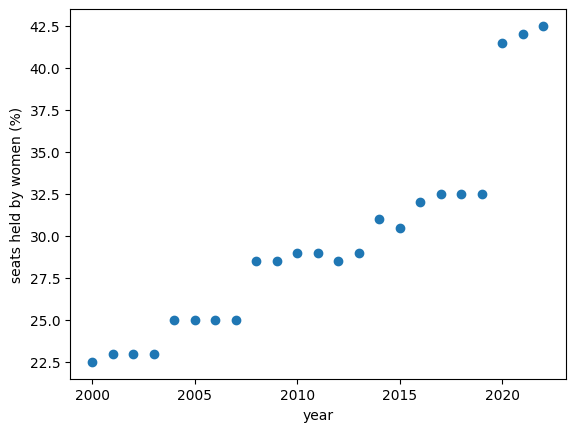

In [7]:
plt.scatter(x, y)
plt.xlabel("year")
plt.ylabel("seats held by women (%)")
plt.show()

In [8]:
res = sm.OLS(y, sm.add_constant(x)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     125.7
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           2.52e-10
Time:                        13:50:56   Log-Likelihood:                -50.594
No. Observations:                  23   AIC:                             105.2
Df Residuals:                      21   BIC:                             107.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1589.9219    144.437    -11.008      0.000   -1890.295   -1289.549
x1             0.8053      0.072     11.213      0.000       0.656       0.955
==============================================================================
Omnibus:                        1.991   Durbin-Watson:                   0.689
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.542
Skew:                           0.616   Prob(JB):                        0.463
Kurtosis:                       2.700   Cond. No.                     6.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

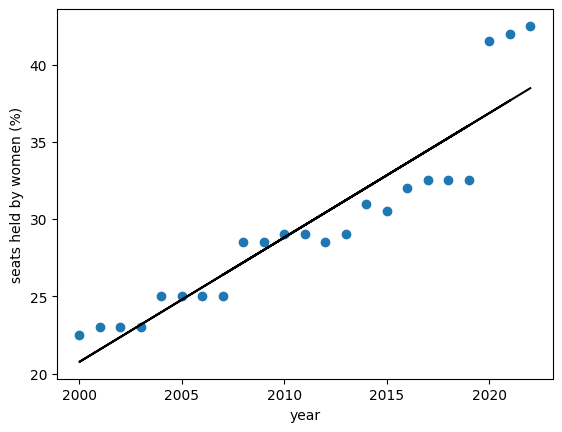

In [9]:
plt.scatter(x, y)
plt.plot(x, res.fittedvalues, 'k')
plt.xlabel("year")
plt.ylabel("seats held by women (%)")
plt.show()

## 2. Parallelizing API requests

API request normally come along with a comparably high latency and therefore are I/O bound. The same is true for web scraping, which is basically equivalent to API calls.

Tasks:
1. Write a function that takes a geoAreaCode and obtains the data for the *proportion of seats held by woman in national parliaments* (seriesCode=SG_GEN_PARL) 
2. Use `concurrent.futures` to parallelize API request (adapt [this example](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor-example)) so that you can obtain data for the geoAreaCodes below in parallel.
3. Write the data that you got from the API to a csv file with the following columns: **geoAreaCode**, **response_json**
4. Calculate the size of your speedup obtained by multithreading.

In [10]:
# all 248 countries/areas
geoAreaCodes = [4, 8, 12, 16, 20, 24, 28, 31, 32, 36, 40, 44, 48, 50, 51, 52, 56, 60, 64, 68, 70, 72, 74, 76, 84, 86, 
                90, 92, 96, 100, 104, 108, 112, 116, 120, 124, 132, 136, 140, 144, 148, 152, 156, 162, 166, 170, 174, 
                175, 178, 180, 184, 188, 191, 192, 196, 203, 204, 208, 212, 214, 218, 222, 226, 231, 232, 233, 234, 238, 
                239, 242, 246, 248, 250, 254, 258, 260, 262, 266, 268, 270, 275, 276, 288, 292, 296, 300, 304, 308, 312, 
                316, 320, 324, 328, 332, 334, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 
                398, 400, 404, 408, 410, 414, 417, 418, 422, 426, 428, 430, 434, 438, 440, 442, 446, 450, 454, 458, 462, 
                466, 470, 474, 478, 480, 484, 492, 496, 498, 499, 500, 504, 508, 512, 516, 520, 524, 528, 531, 533, 534, 
                535, 540, 548, 554, 558, 562, 566, 570, 574, 578, 580, 581, 583, 584, 585, 586, 591, 598, 600, 604, 608, 
                612, 616, 620, 624, 626, 630, 634, 638, 642, 643, 646, 652, 654, 659, 660, 662, 663, 666, 670, 674, 678, 
                680, 682, 686, 688, 690, 694, 702, 703, 704, 705, 706, 710, 716, 724, 728, 729, 732, 740, 744, 748, 752, 
                756, 760, 762, 764, 768, 772, 776, 780, 784, 788, 792, 795, 796, 798, 800, 804, 807, 818, 826, 831, 832, 
                833, 834, 840, 850, 854, 858, 860, 862, 876, 882, 887, 894]

**Gimmick**: You can uncomment and use the @retry decorator to automatically retry in case your internet connection breaks or the API is unresponsive for a moment. This way your script won't break because of these reasons.

In [11]:
@retry(stop=stop_after_attempt(4), wait=wait_random_exponential(multiplier=4,max=60))
def load_SG_GEN_PARL(geoAreaCode):
    url = f'https://unstats.un.org/sdgapi/v1/sdg/Series/SG_GEN_PARL/GeoArea/{geoAreaCode}/DataSlice'
    response = requests.get(url)
    return response.json()

In [12]:
with concurrent.futures.ThreadPoolExecutor(max_workers=40) as executor:
    # schedule the function load_SG_GEN_PARL to be executed in threads and mark each future (this is what 
    # executor.submit() returns as the key for the dictionary) with its geoAreaCode (the value in the dict)
    future_to_geoAreaCode = {executor.submit(load_SG_GEN_PARL, geoAreaCode): geoAreaCode for geoAreaCode in geoAreaCodes}
    
    # wait for the threads to finish (this whole part is optinal, but useful)
    for future in concurrent.futures.as_completed(future_to_geoAreaCode):
        geoAreaCode = future_to_geoAreaCode[future]
        try:
            json_response = future.result()
        except Exception as exc:
            logging.info(f'geoAreaCode {geoAreaCode}: failed with exception {exc}')
        else:
            logging.info(f'geoAreaCode {geoAreaCode}: success')

23-03-16 13:52:00  geoAreaCode 86: success
23-03-16 13:52:00  geoAreaCode 74: success
23-03-16 13:52:00  geoAreaCode 16: success
23-03-16 13:52:00  geoAreaCode 12: success
23-03-16 13:52:00  geoAreaCode 60: success
23-03-16 13:52:00  geoAreaCode 44: success
23-03-16 13:52:00  geoAreaCode 20: success
23-03-16 13:52:00  geoAreaCode 40: success
23-03-16 13:52:00  geoAreaCode 4: success
23-03-16 13:52:00  geoAreaCode 50: success
23-03-16 13:52:00  geoAreaCode 72: success
23-03-16 13:52:00  geoAreaCode 64: success
23-03-16 13:52:00  geoAreaCode 28: success
23-03-16 13:52:00  geoAreaCode 31: success
23-03-16 13:52:00  geoAreaCode 8: success
23-03-16 13:52:00  geoAreaCode 84: success
23-03-16 13:52:00  geoAreaCode 108: success
23-03-16 13:52:00  geoAreaCode 68: success
23-03-16 13:52:00  geoAreaCode 48: success
23-03-16 13:52:01  geoAreaCode 92: success
23-03-16 13:52:01  geoAreaCode 104: success
23-03-16 13:52:01  geoAreaCode 32: success
23-03-16 13:52:01  geoAreaCode 51: success
23-03-16 13

In [13]:
header = ['geoAreaCode', 'response_json']

with open('api_responses.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    rows = [(geoAreaCode, future.result()) for future, geoAreaCode in future_to_geoAreaCode.items()]
    writer.writerows(rows)

With 40 threads, 248 API calls were finished in approximately 10 seconds. At the beginning of the notebook we saw that one API call takes roughly 0.5 seconds. The speed up when transitioning from one thread to 40 threads therefore is 248*0.5s/10s, so approximately 12.